In [1]:
%pip install phonopy nglview pandas matplotlib numpy mdtraj

import os
import shutil
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms

print("Libraries loaded successfully.")

Note: you may need to restart the kernel to use updated packages.
Libraries loaded successfully.


In [2]:
cwd = os.getcwd()

#Create methane.pdb if it doesn't exist
structure_file = "methane.pdb"
if not os.path.exists(structure_file):
    print("methane.pdb not found. Creating a standard one...")
    pdb_content = """TITLE     Methane
ATOM      1  C1  CH4     1       0.000   0.000   0.000  1.00  0.00           C
ATOM      2  H1  CH4     1       0.630   0.630   0.630  1.00  0.00           H
ATOM      3  H2  CH4     1      -0.630  -0.630   0.630  1.00  0.00           H
ATOM      4  H3  CH4     1      -0.630   0.630  -0.630  1.00  0.00           H
ATOM      5  H4  CH4     1       0.630  -0.630  -0.630  1.00  0.00           H
END
"""
    with open(structure_file, "w") as f:
        f.write(pdb_content)
    print("Created methane.pdb")

#Copy CP2K Data Files
source_dir = "/opt/homebrew/Cellar/cp2k/2025.1/share/cp2k/data"
for file in ["GTH_BASIS_SETS", "GTH_POTENTIALS"]:
    src = os.path.join(source_dir, file)
    dst = os.path.join(cwd, file)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"Copied {file}")
    else:
        print(f"Warning: Could not find {file} at {src}")

Copied GTH_BASIS_SETS
Copied GTH_POTENTIALS


In [3]:
print(f"Loading {structure_file}...")
traj = md.load(structure_file)

#Center the molecule in a 10.0 Angstrom box
#(MDTraj uses nm, so multiply by 10)
positions_ang = (traj.xyz[0] * 10.0) - np.mean(traj.xyz[0] * 10.0, axis=0) + 5.0
symbols = [atom.element.symbol for atom in traj.topology.atoms]
cell_size = 10.0
cell = np.eye(3) * cell_size

#Initialize Phonopy
unitcell = PhonopyAtoms(symbols=symbols, cell=cell, positions=positions_ang)
phonon = Phonopy(unitcell, supercell_matrix=np.eye(3))
phonon.generate_displacements(distance=0.01)
supercells = phonon.supercells_with_displacements

print(f"Generated {len(supercells)} displacements to calculate.")

Loading methane.pdb...
Generated 3 displacements to calculate.


In [4]:
import glob

print("Cleaning up old simulation files...")

# Delete old Inputs and Outputs
files_to_remove = glob.glob("methane_*.inp") + glob.glob("methane_*.out")

for f in files_to_remove:
    try:
        os.remove(f)
        print(f"   Deleted {f}")
    except OSError as e:
        print(f"   Could not delete {f}: {e}")

print("Directory clean. Ready for the new run.")


Cleaning up old simulation files...
   Deleted methane_0.inp
   Deleted methane_1.inp
   Deleted methane_1.out
   Deleted methane_0.out
Directory clean. Ready for the new run.


In [5]:
import subprocess

print("Starting CP2K Loop...")
forces_set = []

# Mac Stability Settings, prob not needed on the Linux
env = os.environ.copy() 
env["OMP_NUM_THREADS"] = "1"
env["OMP_STACKSIZE"] = "64M"

# Verify CP2K path
cp2k_exe = "/opt/homebrew/bin/cp2k.ssmp"
if not os.path.exists(cp2k_exe):
    print(f"CRITICAL ERROR: CP2K not found at {cp2k_exe}")
else:
    for i, sc in enumerate(supercells):
        # 1. Format Coords
        coords_str = "".join([f"      {s}  {p[0]:.6f}  {p[1]:.6f}  {p[2]:.6f}\n" for s, p in zip(sc.symbols, sc.positions)])
        
        # 2. Write Input
        inp_content = f"""&GLOBAL
      PROJECT METHANE_{i}
      RUN_TYPE ENERGY_FORCE
      PRINT_LEVEL MEDIUM
    &END GLOBAL
    &FORCE_EVAL
      METHOD Quickstep
      &DFT
        BASIS_SET_FILE_NAME ./GTH_BASIS_SETS
        POTENTIAL_FILE_NAME ./GTH_POTENTIALS
        &MGRID
          CUTOFF 280
        &END MGRID
        &QS
          EPS_DEFAULT 1.0E-10
        &END QS
        &SCF
          SCF_GUESS ATOMIC
          EPS_SCF 1.0E-5
          MAX_SCF 50
          &OT
            MINIMIZER CG
            PRECONDITIONER FULL_SINGLE_INVERSE
          &END OT
          IGNORE_CONVERGENCE_FAILURE .TRUE.
        &END SCF
        &XC
          &XC_FUNCTIONAL PBE
          &END XC_FUNCTIONAL
        &END XC
      &END DFT
      &SUBSYS
        &CELL
          ABC {cell_size} {cell_size} {cell_size}
        &END CELL
        &COORD
    {coords_str}
        &END COORD
        &KIND H
          BASIS_SET DZVP-GTH
          POTENTIAL GTH-PBE-q1
        &END KIND
        &KIND C
          BASIS_SET DZVP-GTH
          POTENTIAL GTH-PBE-q4
        &END KIND
      &END SUBSYS
      &PRINT
        &FORCES ON
        &END FORCES
      &END PRINT
    &END FORCE_EVAL
    """
        inp_file = f"methane_{i}.inp"
        out_file = f"methane_{i}.out"
        with open(inp_file, "w") as f: f.write(inp_content)
        
        print(f"   Processing structure {i+1}/{len(supercells)}...", end="\r")
        
        # 3. Run CP2K
        with open(out_file, "w") as outfile:
            try:
                subprocess.run([cp2k_exe, "-i", inp_file], stdout=outfile, stderr=subprocess.STDOUT, env=env, check=True)
            except subprocess.CalledProcessError:
                print(f"\nCP2K Crashed on structure {i}.")
        
        # 4. Parse Output (UPDATED FOR YOUR VERSION)
        current_forces = []
        if os.path.exists(out_file):
            with open(out_file, "r") as f:
                for line in f:
                    # Look for lines starting with "FORCES|" that contain numbers
                    if line.strip().startswith("FORCES|"):
                        parts = line.split()
                        # Format: FORCES| Atom X Y Z |f|
                        # We need columns 2, 3, 4 (indices 2,3,4)
                        # Check if part 1 is an integer (Atom ID)
                        if len(parts) >= 6 and parts[1].isdigit():
                            try:
                                f_vec = [
                                    float(parts[2]) * 51.422086, # X
                                    float(parts[3]) * 51.422086, # Y
                                    float(parts[4]) * 51.422086  # Z
                                ]
                                current_forces.append(f_vec)
                            except ValueError:
                                continue # Skip header lines if they accidentally match

        if not current_forces:
            print(f"\nForces missing in {out_file}!")
            break
        forces_set.append(current_forces)

    print(f"\nLoop finished. Collected {len(forces_set)} force sets.")

Starting CP2K Loop...
   Processing structure 3/3...
Loop finished. Collected 3 force sets.


Generating Static Spectrum...

--- Vibrational Modes Found (Gamma Point) ---
         THz |        cm^-1 | Status         
---------------------------------------------
    -11.6559 |    -388.8006 | Imaginary      
    -11.6559 |    -388.8006 | Imaginary      
    -11.6559 |    -388.8006 | Imaginary      
      2.8047 |      93.5542 | Physical Mode  
      2.8047 |      93.5542 | Physical Mode  
      2.8047 |      93.5542 | Physical Mode  
     36.6002 |    1220.8501 | Physical Mode  
     36.6002 |    1220.8501 | Physical Mode  
     36.6002 |    1220.8501 | Physical Mode  
     44.0718 |    1470.0756 | Physical Mode  
     44.0718 |    1470.0756 | Physical Mode  
     94.0132 |    3135.9436 | Physical Mode  
     97.7953 |    3262.1008 | Physical Mode  
     97.7953 |    3262.1008 | Physical Mode  
     97.7953 |    3262.1008 | Physical Mode  
---------------------------------------------


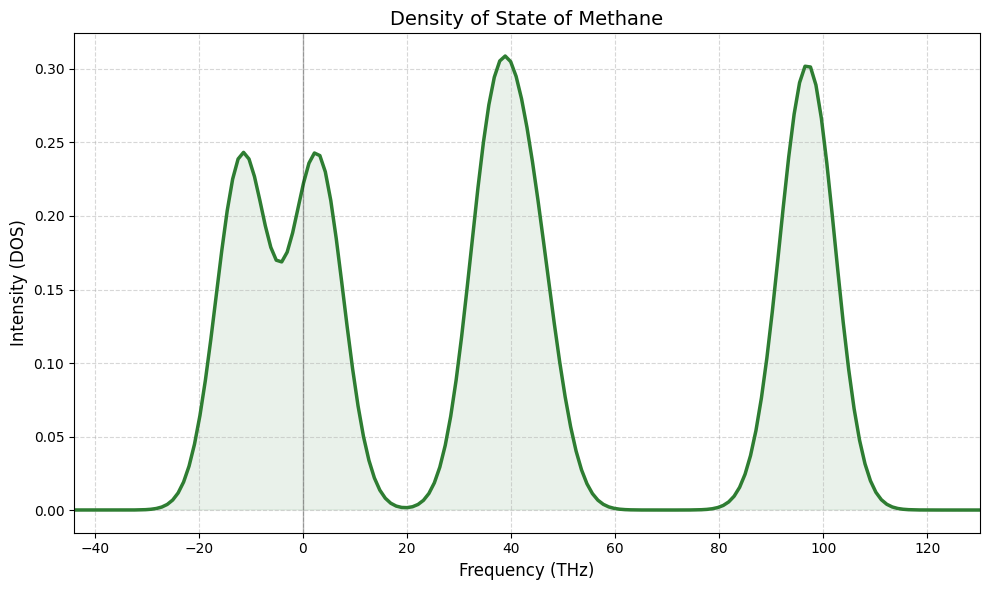

In [8]:
#Using Phonopy


if 'forces_set' not in locals() or not forces_set:
    print("Error: No force data found. Please run the CP2K Loop (Cell 4) first.")
else:
    print("Generating Static Spectrum...")
    
    
    try:
        phonon.produce_force_constants(forces=forces_set)
    except Exception as e:
        print(f"Warning: Force constants issue ({e}). Trying to proceed...")

    # 3. Get Raw Frequencies at Gamma Point (0,0,0)
    phonon.run_qpoints(q_points=[[0, 0, 0]]) 
    raw_freqs = phonon.get_qpoints_dict()['frequencies'][0]
    
    # 4. Print Frequency Table
    print("\n--- Vibrational Modes Found (Gamma Point) ---")
    print(f"{'THz':>12} | {'cm^-1':>12} | {'Status':<15}")
    print("-" * 45)
    
    for f in raw_freqs:
        # Convert THz to Inverse Centimeters (cm^-1)
        # Factor: 1 THz approx 33.356 cm^-1
        wavenumber = f * 33.35641
        
        if f < -0.5:
            status = "Imaginary"
        elif f < 0.5:
            status = "Transl/Rot" # Near-zero modes are translation/rotation
        else:
            status = "Physical Mode"
            
        print(f"{f:12.4f} | {wavenumber:12.4f} | {status:<15}")
    print("-" * 45)

    # 5. Compute Density of States (DOS) for Plotting
    phonon.run_mesh(mesh=[1, 1, 1])
    phonon.run_total_dos(sigma=5.0) 
    total_dos = phonon.get_total_dos_dict()
    
    freqs = total_dos['frequency_points']
    dos = total_dos['total_dos']

    plt.figure(figsize=(10, 6))
    plt.plot(freqs, dos, color='#2E7D32', linewidth=2.5, label='Static Methane (Harmonic Approx.)')
    plt.fill_between(freqs, dos, color='#2E7D32', alpha=0.1)
    
    # Smart Zoom
    positive_peaks = freqs[np.where(dos > 0.01)]
    if len(positive_peaks) > 0:
        plt.xlim(min(positive_peaks) - 20, max(positive_peaks) + 20)
    else:
        plt.xlim(-50, 150)

    plt.xlabel('Frequency (THz)', fontsize=12)
    plt.ylabel('Intensity (DOS)', fontsize=12)
    plt.title('Density of State of Methane', fontsize=14)
    plt.axvline(0, color='black', linewidth=1, alpha=0.3)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()